## Job Interview using Kaggle Competetion of Pneumothorax

- **Author:** Yonghui Li (Aries)
- **Email :** Lyh710@gmail.com
- **Mobile:** 0472 827 179

Note the purpose of this work is **not** for the Kaggle competetion at all, but for a job interview. The aim is to use the Kaggle problem as an example to demonstrate our overall capability as best as we can. All is done within very limited time, and it is a one-off best attempt.

## Git repo: https://github.com/lyh710/kaggle.pneumothorax
- Instead of reviewing this notebook offline, I recommend to review via the corresponding Github repo I created above, which should provide a more robust experience.
- The repo is setup as **public**, but will probably be switched back to **private** after it served the purpose.

## Instruction provided by the recruiter:
1.	Access and download the dataset from the Kaggle competition for Pneunomthorax detection: https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/overview   
2.	Perform appropriate exploratory data analysis and visualisation 
3.	Build a best-effort algorithm to detect a visual signal for Pneunomthorax as per the competition evaluation metric 
4.	Generate appropriate graphs / results table to assess model performance 
5.	Make a baseline submission to the late submission pool 
6.	Discuss shortcomings and the improvements you would make to the dataset, evaluation metrics and algorithm 

## Acknowledgement
To my wife, for keeping the kids occupied and entertained during weekend, so that I can pull this off. Also big kiss to my boys, for allowiing me concentrate on my work, and welcome me join their game when I need a break.

## Disclaim
- I spent approximately **8** hours for this piece of work, scattered from 2020-Aug-28th till 30th (model training time is **NOT** included).
- This is an out-dated Kaggle competetion, which comes with lots of code snippets as well as comments shared by other players or by Kaggle itself. Whenever such information is leveraged, it will be noted in the notebook for clarity. 

## --------------------------------------------------------------------------------------------------------------------------------

## Dev Env Setup
https://github.com/lyh710/kaggle.pneumothorax/tree/master/dnn_gpu_setup_test

- **conda_dnn_gpu_setup.bat**: this piece of work is developed via my personal Dell laptop (AlienWare) with Windows10-Home OS (64bit, 16GB memory). Therefore, the setup batch script is in Win-DOS flavour. But the logic can be transferred to Linux/Mac situation easily. We lock in below python packages as initial env setup:
    - Python=3.7.6
    - Tensorflow-gpu=2.0.0
    - PyTorch=1.4.0
    - numpy 
    - pandas 
    - seaborn 
    - sklearn 
    - progressbar2 
    - **pydicom**
    
- I have the NVIDIA GeForce GTX 1080 (Max-Q 8GB) with my machine, which provides some GPU power for this work. But for formal project, a much more decent computing platform with better GPU capability will be required.For example, the low GPU memory of my machine stops me from using bigger batch size. The fact that I am running this script on a personal laptop, stops me from doing decent number of epochs for training.

**Call out**
- Conda virtual env is the minimum bar for reproducing the work. It may be good enough for a Kaggle competetion or job interview, but may not serve the purpose of formal project. For example, a Docker container to wrap up the conda env could provide more stable and ready to ship model performance, particularly when we may be transiting what we developed here using windows OS to a different OS env, such as Linux/Mac. For production/commerical purpose, we will be operating on cloud or cluster env, proper dev env setup and tesitng will be required, so that model performance can be expected the same, when running on different hard/soft-ware. 

- **DICOM** is the international standard/protocl for medical imaging communication.The data provided in this Kaggle competetion is a relatively simplified scenario, that they all come from the same/similar study/manufacture. Things are expected to be much more complicated in real world, and the DCM images may come from different places, scanned by different machines of different manufacture. Whether the open source package, **pydicom** in this case, can successfully and robustly convert all these DCM images correctly, should be properly tested.

## --------------------------------------------------------------------------------------------------------------------------------

## Packages Loading

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, shutil, pydicom, progressbar, random, pi

import pandas as pd

import numpy as np
np.random.seed(7) # set random seed for reproducibility

import matplotlib.pyplot as plt

# rle utils provided by Kaggle
from mask_functions import *

## --------------------------------------------------------------------------------------------------------------------------------

## Data Explore

- Due to this is an out-dated competetion, the dataset is no longer available via the Cloud Healthcare API. We downloaded via: https://www.kaggle.com/seesee/siim-train-test, which is provided by Kaggle community.
- The downloaded datasete has non-flatten folder structures for each train/test sample, which raised complication to our process. Therefore, we shall first clean up the folder structure. 

Note that, nesting/tree-like folder strucutre is common for **DICOM** data. Each layer/level of the folder indicates corresponding entity, such as "Patient", "Study", "Series", "Instance" etc. The naming of each folder level corresponds to each entity. This Kaggle example is actually giving us a simplified scenario, that there is only one instance for each Study/Series. While this enables us to simplify the folder structure to a much more flatten way, we may need to handle it differently in real world project. In other words, there is room to uplift what we do here regarding data preparation.

### For the code to run correctly, one would need to have a folder named "data" setup in the working directory as shown below:

<img src="imgs/data_setup.png">

1. download the data as described above

2. downloaded Kaggle data should be under "data/siim"

3. "train" and "test" folder should be created and be where we copy the files into respectively

**Note we did NOT commit the data into Git repo due to size.**

In [2]:
def getListOfDcmFiles(dirName):
    '''
    Input a directory (full path)
    Output: all the DICOM file within this directory and sub-folders
    It is done by recursive call of the function itself
    '''
    listOfFile = os.listdir(dirName)
    allFiles = []
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfDcmFiles(fullPath)
        else:
            if os.path.splitext(fullPath)[-1] == '.dcm':
                allFiles.append(fullPath)
                
    return allFiles

def cpDcmFiles(src_dn, trgDir):
    '''
    Copy all DICOM files from source directory (including sub-folders) to target directory
    '''
    assert os.path.isdir(src_dn)
    assert os.path.isdir(trgDir)
    
    allFiles = getListOfDcmFiles(src_dn)
    
    bar = progressbar.ProgressBar(max_value=len(allFiles))
    for i in range(len(allFiles)):
        fn     = allFiles[i]
        trg_fn = os.path.join(trgDir, os.path.basename(os.path.normpath(fn)))
        if os.path.exists(trg_fn):
            os.remove(trg_fn)
        shutil.copy(fn, trg_fn)
        bar.update(i)
        
src_dn   = os.path.join(os.getcwd(),'data', 'siim', 'dicom-images-train')
trg_dn   = os.path.join(os.getcwd(),'data', 'train')
cpDcmFiles(src_dn, trg_dn)
print('There are {} DICOM files in train'.format(len(os.listdir(trg_dn))))

src_dn   = os.path.join(os.getcwd(),'data', 'siim', 'dicom-images-test')
trg_dn   = os.path.join(os.getcwd(),'data', 'test')
cpDcmFiles(src_dn, trg_dn)
print('There are {} DICOM files in test'.format(len(os.listdir(trg_dn))))

 99% (12086 of 12089) |################# | Elapsed Time: 0:04:20 ETA:   0:00:00

There are 12089 DICOM files in train


 99% (3203 of 3205) |################### | Elapsed Time: 0:01:07 ETA:   0:00:00

There are 3205 DICOM files in test


## Label (mask) info

train-rle.csv

Introduction provided by Kaggle has confirmed the below:
- Given the DCM image ID, "-1" means **negative** sample
- Given the DCM image ID, run-length-encoded (RLE) means **positive** sample and the detail location (mask) of the pneumothorax 

In [3]:
# Quick peek of the label/mask spreadsheet

fn           = os.path.join(os.getcwd(),'data', 'train-rle.csv')
df_train_rle = pd.read_csv(fn)

print(df_train_rle.shape)
print(df_train_rle.dtypes)
print(len(df_train_rle['ImageId'].unique()))

df_train_rle.head(2).values

(12954, 2)
ImageId           object
 EncodedPixels    object
dtype: object
12047


array([['1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819', '-1'],
       ['1.2.276.0.7230010.3.1.4.8323329.13666.1517875247.117800',
        '557374 2 1015 8 1009 14 1002 20 997 26 990 32 985 38 980 42 981 42 979 43 978 45 976 47 964 59 956 66 925 98 922 101 917 106 916 106 916 107 914 109 909 113 907 116 904 118 903 120 902 120 902 121 900 122 899 124 898 124 898 125 897 125 898 125 896 126 895 127 895 128 895 128 895 128 894 128 895 128 895 128 895 128 895 128 895 128 894 130 893 130 893 130 893 130 893 129 894 129 894 129 894 129 895 127 897 126 898 126 898 125 898 126 898 125 899 125 899 125 899 124 900 124 900 125 899 125 899 125 899 125 899 126 898 127 897 128 897 128 896 129 895 130 894 132 892 133 891 134 890 136 888 137 888 137 887 139 885 140 884 141 884 141 883 142 882 143 881 145 879 146 879 147 878 147 877 149 876 150 874 153 872 153 871 154 871 154 870 155 870 154 870 154 870 154 871 153 871 154 871 154 870 154 871 154 870 155 869 155 870 155 869 155 869 155 869 15

### Two observations can be seen from inspecting the spreadsheet:
- There is whitespace character within the column name (EncodedPixels), which is better addressed upfront before proceeding
- The count of unique DCM image IDs in the spreadsheet is less than the total count of records, which is clarified by Kaggle that some training images have multiple annotations.

In [4]:
# Rename the columns by strip space

for col in df_train_rle.columns:
    df_train_rle.rename(columns={col: col.strip()}, inplace=True)
    
print(df_train_rle.dtypes)

ImageId          object
EncodedPixels    object
dtype: object


In [5]:
# Show DCM image ID that have multiple EncodedPixels info

df_cnt = df_train_rle.groupby('ImageId').agg(['count'])
dup_dcm_ids = df_cnt[df_cnt['EncodedPixels']['count']>1].index
print('There are {} DCM IDs with multiple annotations '.format(len(dup_dcm_ids)))
dup_dcm_ids

There are 624 DCM IDs with multiple annotations 


Index(['1.2.276.0.7230010.3.1.4.8323329.10011.1517875220.977487',
       '1.2.276.0.7230010.3.1.4.8323329.10012.1517875220.965942',
       '1.2.276.0.7230010.3.1.4.8323329.10034.1517875221.47394',
       '1.2.276.0.7230010.3.1.4.8323329.10050.1517875221.763035',
       '1.2.276.0.7230010.3.1.4.8323329.10060.1517875221.792744',
       '1.2.276.0.7230010.3.1.4.8323329.10078.1517875221.860801',
       '1.2.276.0.7230010.3.1.4.8323329.10088.1517875221.907774',
       '1.2.276.0.7230010.3.1.4.8323329.10093.1517875221.950467',
       '1.2.276.0.7230010.3.1.4.8323329.10098.1517875222.57431',
       '1.2.276.0.7230010.3.1.4.8323329.10099.1517875222.78541',
       ...
       '1.2.276.0.7230010.3.1.4.8323329.5704.1517875189.675934',
       '1.2.276.0.7230010.3.1.4.8323329.5710.1517875189.709115',
       '1.2.276.0.7230010.3.1.4.8323329.5746.1517875190.97136',
       '1.2.276.0.7230010.3.1.4.8323329.5747.1517875190.107803',
       '1.2.276.0.7230010.3.1.4.8323329.5749.1517875190.142037',
       '

In [6]:
# One example of multiple annotation

df_train_rle[df_train_rle['ImageId']==dup_dcm_ids[0]]

,ImageId,EncodedPixels
5450,1.2.276.0.7230010.3.1.4.8323329.10011.15178752...,49820 3 1017 11 1012 13 1009 16 1007 18 1006 1...
9058,1.2.276.0.7230010.3.1.4.8323329.10011.15178752...,891504 5 1018 8 1015 10 1013 12 1011 14 1009 1...
10109,1.2.276.0.7230010.3.1.4.8323329.10011.15178752...,659506 1 1022 5 1018 6 1017 8 1014 10 1012 12 ...


## Do we have all the DCM training images mentioned in the spreadsheet?

In [7]:
miss_train = []
for x in df_train_rle['ImageId'].unique():
    fn = os.path.join(os.getcwd(), 'data', 'train', x+'.dcm')
    if not os.path.exists(fn):
        miss_train.append(fn)

print('There are {} DCM image missed from the spreadsheet'.format(len(miss_train)))

There are 0 DCM image missed from the spreadsheet


We have **all** the DCM training samples mentioned in the spreadsheet, good to proceed

### View some random DCM images

- Below 2 utils are provided by https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data
- The original code snippet has a bug around the "fn", which I fixed accordingly to make it work

In [8]:
def show_dcm_info(fn, dataset):
    print("Filename.........:", fn)
    print("Storage type.....:", dataset.SOPClassUID)
    print()

    pat_name = dataset.PatientName
    display_name = pat_name.family_name + ", " + pat_name.given_name
    print("Patient's name......:", display_name)
    print("Patient id..........:", dataset.PatientID)
    print("Patient's Age.......:", dataset.PatientAge)
    print("Patient's Sex.......:", dataset.PatientSex)
    print("Modality............:", dataset.Modality)
    print("Body Part Examined..:", dataset.BodyPartExamined)
    print("View Position.......:", dataset.ViewPosition)
    
    if 'PixelData' in dataset:
        rows = int(dataset.Rows)
        cols = int(dataset.Columns)
        print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
            rows=rows, cols=cols, size=len(dataset.PixelData)))
        if 'PixelSpacing' in dataset:
            print("Pixel spacing....:", dataset.PixelSpacing)

def plot_pixel_array(dataset, figsize=(10,10)):
    plt.figure(figsize=figsize)
    plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
    plt.show()

Filename.........: D:\Git\kaggle.pneumothorax\data\train\1.2.276.0.7230010.3.1.4.8323329.2198.1517875171.603544.dcm
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name......: cc45a5af-126d-485f-ad8d-4ef14d794a85, 
Patient id..........: cc45a5af-126d-485f-ad8d-4ef14d794a85
Patient's Age.......: 66
Patient's Sex.......: M
Modality............: CR
Body Part Examined..: CHEST
View Position.......: PA
Image size.......: 1024 x 1024, 114302 bytes
Pixel spacing....: [0.168, 0.168]


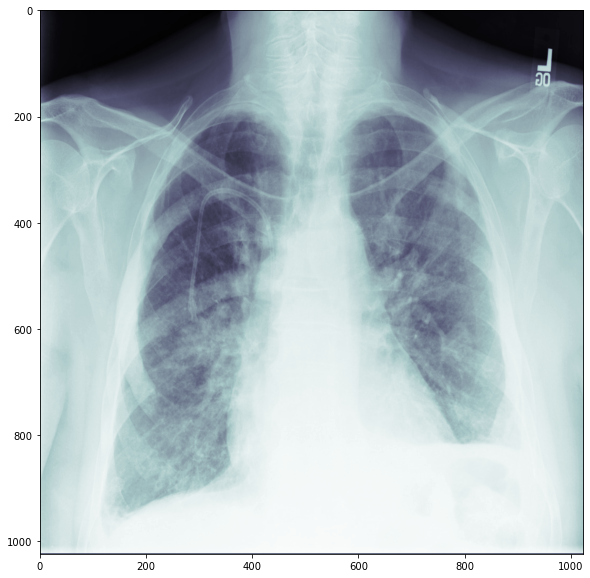

In [9]:
# one random DCM image to view
dcm_id  =  np.random.choice(df_train_rle['ImageId'].unique())
fn      = os.path.join(os.getcwd(), 'data', 'train', dcm_id+'.dcm')
dataset = pydicom.dcmread(fn)
show_dcm_info(fn, dataset)
plot_pixel_array(dataset)

**Call out** 

We shall pay cautious regarding the **"Left/Right"** of the DCM image. Human body is highly symmetric (maybe less so regarding chest, but very much so regarding brain). The recommended practice is to have "marker" on designated side of the subject when scanning, so that we will have golden truth regarding "Left/Right". This can be achieved by: 
1. Small cube of water/oil/plastic placed to specific side of the subject. 
2. If certain subject has obvious marker on their body (known to have tumour/surgery in the left lung from previous diagnosis for example), then these subjects can serve the purpose of "Left/Right" check during our DCM data processing. 

We don't need to do this for every instance. As long as the scan is done by the same machine on the same site with the same setup, a few samples of such practice should be good enough. We only need to repeat such procedure, when it is a multi-site or multi-machine projects, or machine setup (hard/soft-ware) been modified (upgraded) during project.

We can observe a "L" marker within all the DCM images we checked, but the style of it varies across samples, which indicates the possibility of these samples may be coming from different sites (hospitals), scanned by different machines. It further highlights the need of the ground-truth check of "Left/Right" if this is one single project of us.

### Over lay with the Label/Mask of pneumothorax 

- mask_functions.py comes with the dataset, which I assume either provided by Kaggle, or by who prepared the dataset
- A transpose seems necessary for correct position of the mask over the given DCM image, which is a tip shared by other player

**Call out**
- I can **NOT** verify whether the Label/Mask is correctly overlay on the DCM image, simply because I don't have the expertise regarding  pneumothorax. In other words, I can **NOT** verify whether the util function as well as the transpose tip provided by Kaggle (or other player) is indeed correct.
- In actual project, we should **NOT** be waiting for data prepared and handed to us. Instead, we should be on top of the data acquisition, as well as the annotation (label/mask) generation ourselves. It is the best way to have Quality-Control around the process.This clearly highlight the need for ML/AI practiciationer to collaborate with clinical/heath-care expertise (radiologist) in the first place. The **worst** case of this issue, is I may have messed up the label/mask layout completely, which naturally means the resulted model will be **useless**.
- The best effort I can try at this point in time, is with the below **6** possibility of "flipping" the mask image:
    1. mask provided as the original util funtion (lets refer it as RAW)
    2. flip RAW vertically
    3. flip RAW horizontally
    4. transpose RAW as suggested by Kaggle/Other (lets refer it as RAW_Tran)
    5. flip RAW_Tran vertically
    6. flip RAW_Tran horizontally
    
I will judge by my own eye-balling and common sense: whether the mask appears "within" lung area, and whether it is consistently across the random samples I checked
    
This issue we encountered is very common when dealing with medical imaging, similar to "Left/Right". Any pitfall during the data acquisition/pre-processing work flow, and the fail to address those pitfalls, will lead to a failure of the project, no matter how great the Deep-Learning we are doing.

**Note one can re-run the below code cell as many times as they want, each time will show a random DCM image (with pneumothorax) and the corresponding 6 layout of mask for eye-balling review**

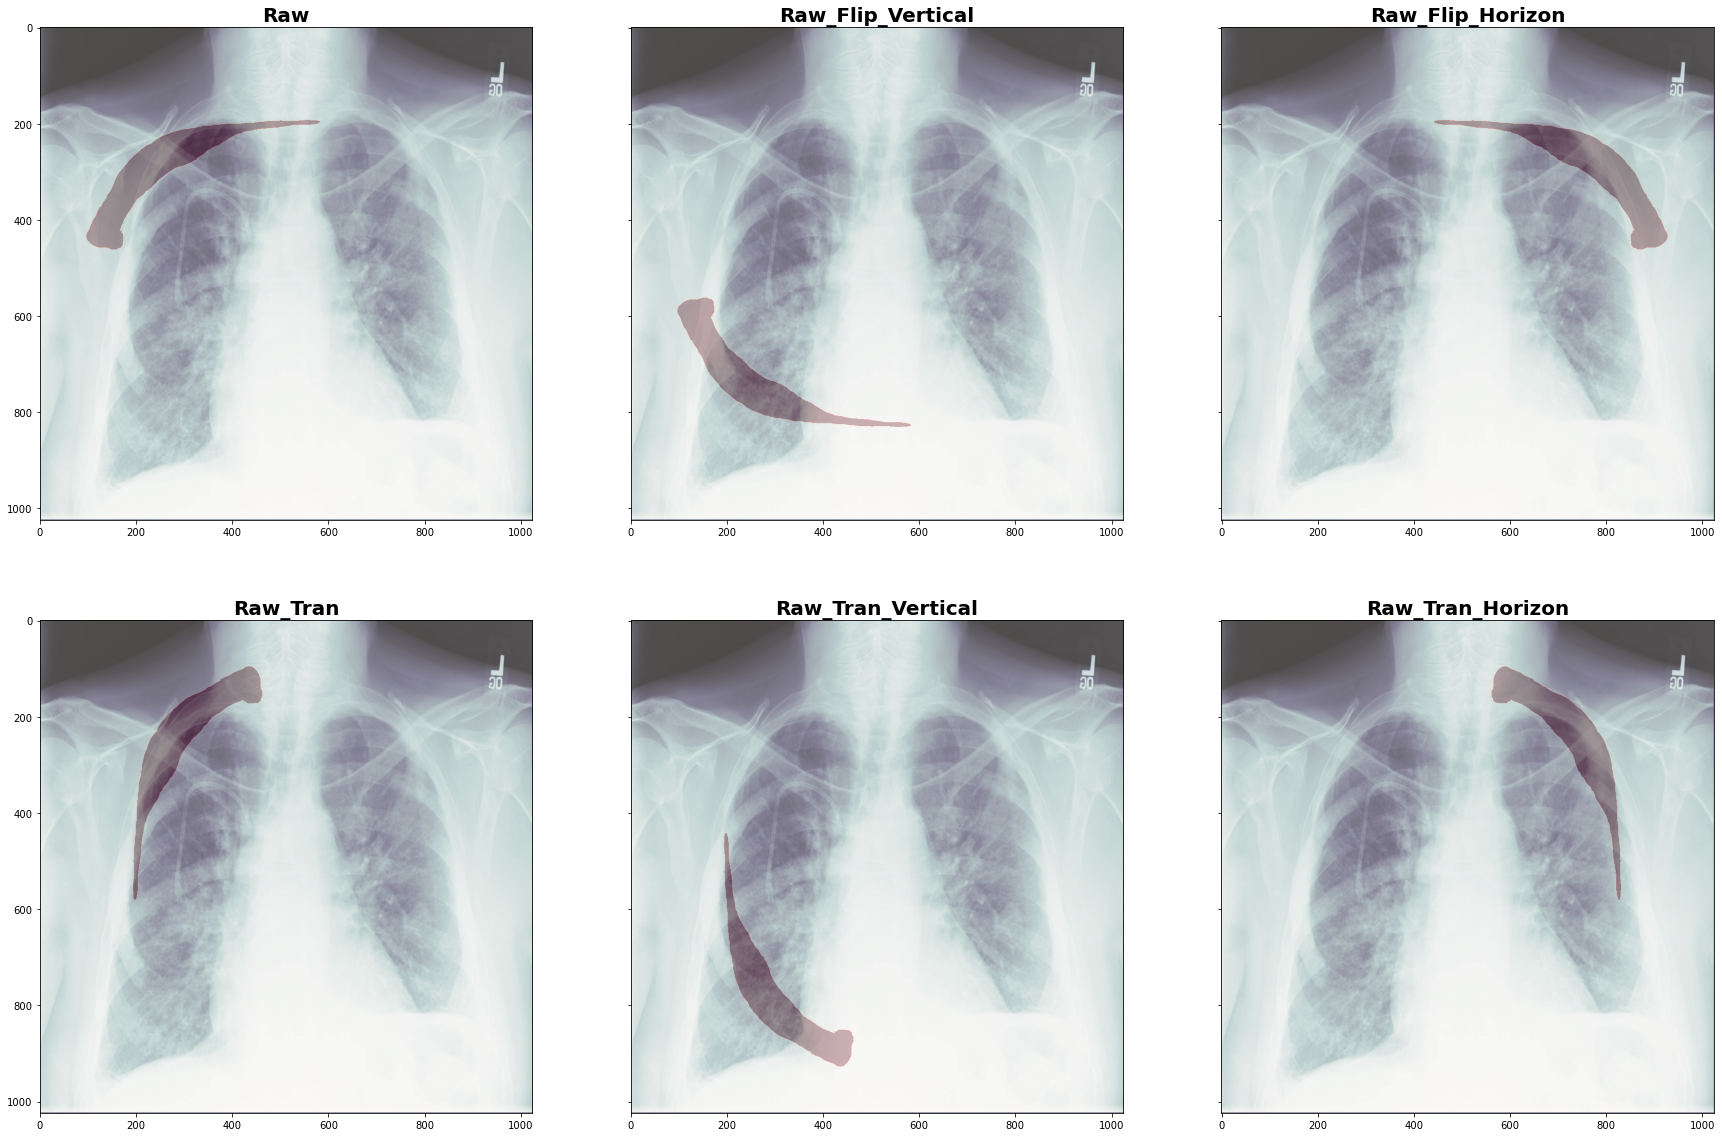

In [30]:
# We will present the same DCM image 6 times, each with one of the 6 possible "flip"
titles = ['Raw', 'Raw_Flip_Vertical', 'Raw_Flip_Horizon', 'Raw_Tran', 'Raw_Tran_Vertical', 'Raw_Tran_Horizon']

# one random Positive sample
dcm_id  =  np.random.choice(df_train_rle[df_train_rle['EncodedPixels'] != '-1']['ImageId'].unique())
# print(dcm_id)

dcm_fn  = os.path.join(os.getcwd(), 'data', 'train', dcm_id+'.dcm')
dataset = pydicom.dcmread(fn)
X       = dataset.pixel_array

rles    = df_train_rle[df_train_rle['ImageId']==dcm_id]['EncodedPixels']
Y       = np.zeros((1024, 1024))
# In case of multiple instance, Y shall be the "sum" of them
for rle in rles:
    mask = rle2mask(rle, 1024, 1024)
    Y    = Y + mask

# 6 possible flips of Y    
Ys = [Y, np.flip(Y, axis=0), np.flip(Y, axis=1), Y.T, np.flip(Y.T, axis=0), np.flip(Y.T, axis=1)]    

fig, axs = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(30, 20))
for i in range(len(Ys)):
    axs.flatten()[i].set_title(titles[i], fontweight="bold", size=20)
    axs.flatten()[i].imshow(X, cmap=plt.cm.bone)
    axs.flatten()[i].imshow(Ys[i], alpha=0.3, cmap="Reds")
    

<font color='red'>**Note:**
- "Raw_Tran" and "Raw_Tran_Horizon" seem to be the 2 most "sensible" possibilities. In which, "Raw_Tran" is the suggested way by Kaggle/Other-player. The other 4 possibilities tend to consistently place the mask outside of lung area.
- However, between "Raw_Tran" and "Raw_Tran_Horizon", either will have samples that is not-so acceptable to my eye-balling.
- For this job interview sake, we will proceed with "Raw_Tran", due to all the information available to me. But there is still the possibility that this may be messing the Label/Mask completely, hence will lead to failure of the neural net outcome, regardless how good the neural net is designed and trained later on.
</font>

### DCM image pixel intesity distribution

<class 'numpy.ndarray'> (1024, 1024)
210 0


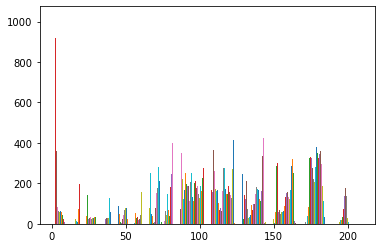

In [31]:
# one random DCM image
dcm_id  =  np.random.choice(df_train_rle['ImageId'].unique())
fn      = os.path.join(os.getcwd(), 'data', 'train', dcm_id+'.dcm')
dataset = pydicom.dcmread(fn)
dcm_img = dataset.pixel_array
print(type(dcm_img),dcm_img.shape)
print(np.max(dcm_img), np.min(dcm_img))
plt.hist(dcm_img)
plt.show()

- Kaggle has made it easier for us, that the DCM image is range (0, 255)
- DCM image is black-white, meaning only "one" colour channel

## --------------------------------------------------------------------------------------------------------------------------------

### Attempt to load all training images into memeory

- Below code block is referencing https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data, but modified to work in our setup
- I take the **transpose** being the way to handle the label/mask, acknowledging issue already mentioned above.
- We normalise the images and masks to [0, 1]

In [10]:
# All the training sample
train_img_list = df_train_rle['ImageId'].unique()

# shuffle the samples
random.shuffle(train_img_list)

# Image hyper-para
im_height      = 1024
im_width       = 1024
im_chan        = 1

# Start the load
X_all          = np.zeros((len(train_img_list), im_height, im_width, im_chan), dtype=np.int8)
Y_all          = np.zeros((len(train_img_list), im_height, im_width, 1), dtype=np.bool)
bar            = progressbar.ProgressBar(max_value=len(train_img_list))
for i in range(len(train_img_list)):
    
    # DCM image ID
    dcm_id = train_img_list[i]
    
    # Load corresponding Image - X
    fn = os.path.join(os.getcwd(), 'data', 'train', dcm_id+'.dcm')
    if not os.path.exists(fn):
        print('{} is missing'.format(fn))
    else:
        # Normalise to [0, 1] by devided by 255
        X_all[i] = np.expand_dims(pydicom.dcmread(fn).pixel_array/255, axis=2)
        
    # Load corresponding Label/Mask(s) - Y (transpose)
    rles = df_train_rle[df_train_rle['ImageId']==dcm_id]['EncodedPixels'].values.tolist()
    if len(rles) == 1:
        rle = rles[0]
        if rle == '-1':
            # Negative sample
            Y_all[i] = np.zeros((1024, 1024, 1))
        else:
            # Positive with only one instance
            mask = rle2mask(rle, 1024, 1024).T  # Transpose
            Y_all[i] = np.expand_dims(mask, axis=2)
    else:
        # Positive with Multiple instances
        Y_all[i] = np.zeros((1024, 1024, 1))
        for rle in rles:
            mask     = rle2mask(rle, 1024, 1024).T # Transpose
            Y_all[i] = Y_all[i] + np.expand_dims(mask, axis=2)
        
    bar.update(i)

print(np.max(X_all), np.max(Y_all))
print(np.min(X_all), np.min(Y_all))

 99% (12043 of 12047) |################# | Elapsed Time: 0:07:27 ETA:   0:00:00

1 True
0 False


## --------------------------------------------------------------------------------------------------------------------------------

### Hold out a portion from the training data as "valid", which we know the ground truth (compared to the "test")

Our thinking is to have as many samples for training as possible, while the hold out "valid" set should have comparable class ratio as "train"

In [19]:
split_thr = 0.9
split_cut = round(X_all.shape[0]*split_thr)

X_train   = X_all[:split_cut,...]
Y_train   = Y_all[:split_cut,...]
print('X_train.shape: {}, Y_train.shape: {}, positive class ratio: {}'.format(X_train.shape, Y_train.shape, np.sum((np.sum(Y_train, axis=(1,2,3)))>1)/Y_train.shape[0]))

X_valid   = X_all[split_cut:,...]
Y_valid   = Y_all[split_cut:,...]
print('X_valid.shape: {}, Y_valid.shape: {}, positive class ratio: {}'.format(X_valid.shape, Y_valid.shape, np.sum((np.sum(Y_valid, axis=(1,2,3)))>1)/Y_valid.shape[0]))


X_train.shape: (10842, 1024, 1024, 1), Y_train.shape: (10842, 1024, 1024, 1), positive class ratio: 0.22154584025087623
X_valid.shape: (1205, 1024, 1024, 1), Y_valid.shape: (1205, 1024, 1024, 1), positive class ratio: 0.22157676348547717


## --------------------------------------------------------------------------------------------------------------------------------

### This problem can be viewed as "Image Segmentation" fundamentally

The task for us is to train a neural network to output a pixel-wise mask of the image, which to show the location of Pneumothorax. In this case, the output class is either 1 (Pneumothorax) or 0 (negative).

- The U-Net is recommended by both Tensorflow and Kaggle community as the go-to starting point:
    - https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/
    - https://arxiv.org/abs/1505.04597
- We believe this is fair starting point, because the u-net method is specifically developed for biomedical imaging segmentation with relatively small sample size

In [20]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from tensorflow.keras.callbacks import TensorBoard, Callback, ModelCheckpoint, LambdaCallback, LearningRateScheduler

### Make sure GPU is ready

In [21]:
assert tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


### For the sake of this work, we use run-time-stamp as model version ID

In [22]:
from time import time

# specify model version
model_version  = 'model.'+str(time())

# Prepar folder to output model
out_dir = os.path.join(os.getcwd(), 'models', model_version)
if os.path.isdir(out_dir):
    shutil.rmtree(out_dir)
os.mkdir(out_dir)

### Set up Callbacks

In [23]:
# checkpoint
fn = os.path.join(out_dir, model_version+'_checkpoint_epoch.hdf5')
checkpoint_epoch = ModelCheckpoint(fn, monitor='val_loss', save_best_only=True, mode = 'min')

In [24]:
# set Tensorboard
tensorboard = TensorBoard(log_dir=os.path.join(os.getcwd(), 'logs', model_version))

### DICE metric requested by Kaggle

In [25]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

### Baseline Model with U-Net

Below network architecture is recommended by other Kaggle player: https://www.kaggle.com/jesperdramsch/intro-chest-xray-dicom-viz-u-nets-full-data

In [26]:
def get_model(im_chan):
    inputs = Input((None, None, im_chan))

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (inputs)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same') (c5)
    p5 = MaxPooling2D(pool_size=(2, 2)) (c5)

    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (p5)
    c55 = Conv2D(128, (3, 3), activation='relu', padding='same') (c55)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c55)
    u6 = concatenate([u6, c5])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u71 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u71 = concatenate([u71, c4])
    c71 = Conv2D(32, (3, 3), activation='relu', padding='same') (u71)
    c61 = Conv2D(32, (3, 3), activation='relu', padding='same') (c71)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c61)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
    model.summary()
    
    return model

In [27]:
model = get_model(1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 8 80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 8 584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, None, None, 8 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

### DNN architecture can be viewed as below (from tensorboard)

<img src="imgs/model.1598838977.4807327_train.png">

### Start training
- Due to the limit of our GPU memoery, batch-size can only be set up 8
- For a quick glance of end-to-end, epochs set up 5 (which took around 1.5 hours already)

**It is very clear that my personal gaming computer is not for this purpose, and more high end computing env is required to do this properly.**

In [28]:
# train
history = model.fit(  X_train
                    , Y_train
                    , batch_size=8
                    , epochs=5
                    , validation_data=(X_valid, Y_valid)
                    , verbose=1
                    , callbacks=[checkpoint_epoch, tensorboard])

Train on 10842 samples, validate on 1205 samples
Epoch 1/5
10842/10842 [==============================] - 738s 68ms/sample - loss: 0.0331 - dice_coef: 0.0027 - val_loss: 0.0220 - val_dice_coef: 0.0039
Epoch 2/5
10842/10842 [==============================] - 705s 65ms/sample - loss: 0.0202 - dice_coef: 0.0031 - val_loss: 0.0219 - val_dice_coef: 0.0042
Epoch 3/5
10842/10842 [==============================] - 700s 65ms/sample - loss: 0.0198 - dice_coef: 0.0033 - val_loss: 0.0226 - val_dice_coef: 0.0030
Epoch 4/5
10842/10842 [==============================] - 697s 64ms/sample - loss: 0.0197 - dice_coef: 0.0034 - val_loss: 0.0220 - val_dice_coef: 0.0037
Epoch 5/5
10842/10842 [==============================] - 697s 64ms/sample - loss: 0.0200 - dice_coef: 0.0030 - val_loss: 0.0222 - val_dice_coef: 0.0037


In [32]:
# output the model to disk
fn = os.path.join(out_dir, model_version+'.hdf5')
if os.path.exists(fn):
    os.remove(fn)
model.save(fn)

# output the history to disk
fn = os.path.join(out_dir, model_version+'.history.pkl')
if os.path.exists(fn):
    os.remove(fn)
with open(fn, 'wb') as f:
    pickle.dump(history.history, f)

# Save the script
src_fn = os.path.join(os.getcwd(), 'harrison.ipynb')
trg_fn = os.path.join(out_dir, 'harrison.ipynb')
if os.path.exists(trg_fn):
    os.remove(trg_fn)
shutil.copy(src_fn, trg_fn)

NameError: name 'pickle' is not defined